For this tutorial about time series we will use a dataset provided by CitiBike, a bike sharing system in NYC. You can download the data here https://s3.amazonaws.com/tripdata/202112-citibike-tripdata.csv.zip

In [3]:
import pandas as pd
import altair as alt
import numpy as np
import datetime as dt
data = pd.read_csv('../data/202112-citibike-tripdata.csv')

C:\Users\huang\AppData\Local\Temp\ipykernel_5980\440401538.py:5: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('202112-citibike-tripdata.csv')


# Defining the Problem

We can start by taking a look at the structure of the data. The column names are descriptive of the nature of the variable

In [4]:
data.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,72D1C9F1A2FEB359,classic_bike,2021-12-04 17:53:23,2021-12-04 18:05:37,Irving Ave & Halsey St,4695.04,Central Ave & Himrod St,4713.01,40.694670,-73.906630,40.696760,-73.923020,casual
1,8BE7469E1A90508C,electric_bike,2021-12-04 17:35:04,2021-12-04 17:52:55,W 25 St & 6 Ave,6215.04,W 29 St & 9 Ave,6416.06,40.743954,-73.991449,40.750073,-73.998393,casual
2,AF9EDCC2A347E607,electric_bike,2021-12-13 23:59:41,2021-12-14 00:08:31,Irving Ave & Halsey St,4695.04,Harman St & Seneca Ave,5002.09,40.694670,-73.906630,40.705770,-73.912920,casual
3,495CF3C8A1B7FED8,classic_bike,2021-12-22 12:22:38,2021-12-22 12:25:46,Lenox Ave & W 115 St,7627.1,Central Park North & Adam Clayton Powell Blvd,7617.07,40.801194,-73.950074,40.799484,-73.955613,member
4,1C138E3D55FCC7C1,classic_bike,2021-12-16 10:15:22,2021-12-16 10:32:02,W 26 St & 10 Ave,6382.05,W Broadway & Spring St,5569.06,40.749718,-74.002950,40.724947,-74.001659,member


This data is currently a set of rides. In order to use this data as a time series dataset, we will need to transform it. We can also look at the dates and find that this dataset is for one month of rides.

In [5]:
data['started_at'].min()

'2021-12-01 00:00:04'

In [6]:
data['started_at'].max()

'2021-12-31 23:59:46'

Time series, like all data science problems require careful problem definition. There are a few thing to keep in mind when designing time series solutions:
1. Time series models work best when you have equally spaced points, so pick a timescale that is useful. If I put myself in the shoes of a CitiBike operator, I would be most interested in hourly data.
2. Forecasts will generally work better on shorter time horizons. It is probably easier to estimate the hourly flows tomorrow rather than a week from now. It is also important to consider how long it takes to train your model and serve predictions. If you build a model that predicts hourly flows 1 hours out, but it takes 2 hours to gather all the relevant data, it will not be a practical model.
3. Try to aggregate your data as much as possible. In our dataset, we have about 2000 stations. If we needed station level predictions, we would need to output 2000 predictions every hour. If we only needed to predict total traffic to the network, we would only need to provide 1 prediction per hour. Furthermore, the uncertainty in the sum of the arrivals of the stations is going to be less than the sum of the uncertainty of the arrivals of individual stations. For operational purposes, it would make sense to cluster the stations and predict the sums of the clusters. As a user, I am likely willing to walk a certain amount to find a bike, so grouping stations within this distance would make sense. For simplicity, we will only consider network level predictions.

Thus, we will define the problem as follows. We want to provide hourly estimates for the next 24 hours every day at 6:00 AM. Imagine that every day operators look at this hourly forecast to look at rebalancing operations

#### communicate these with stakeholders before you start analysis is very important


# Transforming the Data

We want the number of rows for each hour. Luckily, pandas has functionality for these type of aggregations

In [7]:
data['started_at'] = pd.to_datetime(data['started_at'])
hourly_counts = data['started_at'].dt.floor('h').value_counts().sort_index().reset_index()

In [12]:
# value_counts use datetimeindex to count the number of rows, and then sort_index and reset_index
data['started_at'].dt.floor('h').value_counts().index[:3]

DatetimeIndex(['2021-12-02 18:00:00', '2021-12-02 17:00:00',
               '2021-12-06 17:00:00'],
              dtype='datetime64[ns]', freq=None)

In [13]:
hourly_counts.columns = ['hour', 'num_rides']
hourly_counts.shape

(744, 2)

The data has 744 rows because there are 31 days in December and 24 hours in each day

In [14]:
alt.Chart(hourly_counts).mark_line().encode(x = 'hour', y = 'num_rides')

alt.Chart(...)

In [15]:
alt.Chart(hourly_counts[:168]).mark_line().encode(x = 'hour', y = 'num_rides')

alt.Chart(...)

These two plots show a few things. First, we see the volume in the last week of December is less than the volume during the rest of the month, likely due to Christmas vacation. To gather more data about that hypothesis, we would need to look at other holiday periods and see if there is a similar decline.

The second plot shows the trend for the first week of December. On most days, there are two peaks. The days with only one peak are December 4, and December 5 which are Saturday and Sunday. Therefore, a plausible explanation for this data is that during weekdays, we see two peaks before and after the workdays. 

Unsurprisingly, there is a daily cycle where people ride the bikes during the day and use them much less frequently during the night

# Exploration of Data

A great way to start exploring time series data is to look at autocorrelation. Doing machine learning with time series data is very similar to machine learning in other contexts. One of the features you can use are lagged variables or autoregressive features. In our example, lagged variables would be the hourly counts from previous hours. Autocorrelation measures the correlation coefficient (between -1 and 1) between different lags

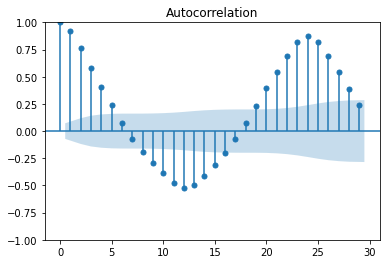

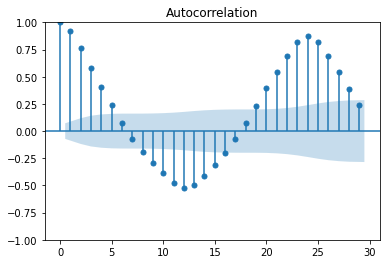

In [13]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(hourly_counts['num_rides'])

In the plot above, the x-axis refers to the amount of lag, and the y axis is the correlation coefficient. The point at 0 has a correlation of 1 because the two series being compared are the same. There is a negative autocorrelation on cycles of 12 hours because a 12 hour shift corresponds to a day-night difference. We also see the lags with the highest correlation are around 1 and 24, meaning the most recent hourly counts and the hourly counts for the same hour from 1 day ago provide the most predictive value. 

A related plot to the autocorrelation plot is the partial autocorrelation plot. The idea is the same, but now instead of just the correlation, the y-axis shows the marginal correlation added when including a lagged variable that is not already captured by the lower lag variables.

/Users/rohpitre/projects/venv/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


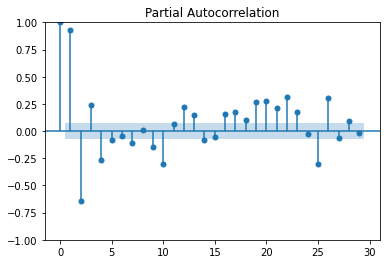

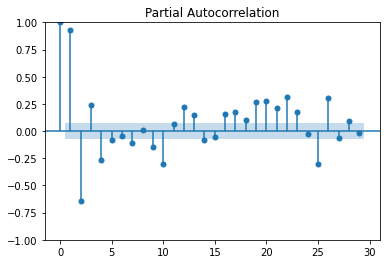

In [15]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(hourly_counts['num_rides'])

These plots should give visual intuition in how many lagged features to use

# Validation of Models

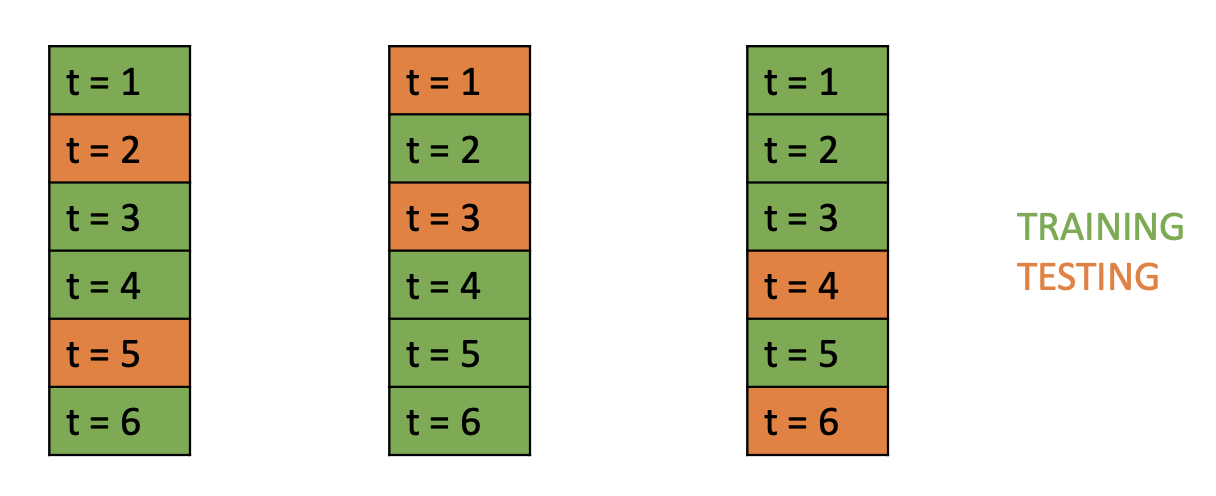

In the figure above, we see how using 3-fold validation on a simplified dataset of 6 time series points. Consider the leftmost fold. In that case we are using data from time t = 6 in our training and trying to predict what happends in t = 5. This is not indicative of what happens in reality. You will never have future information. Thus, we cannot randomly split our data. Rather we must do validation like in the following diagram. Here the, cells in white are ignored in their corresponding fold.

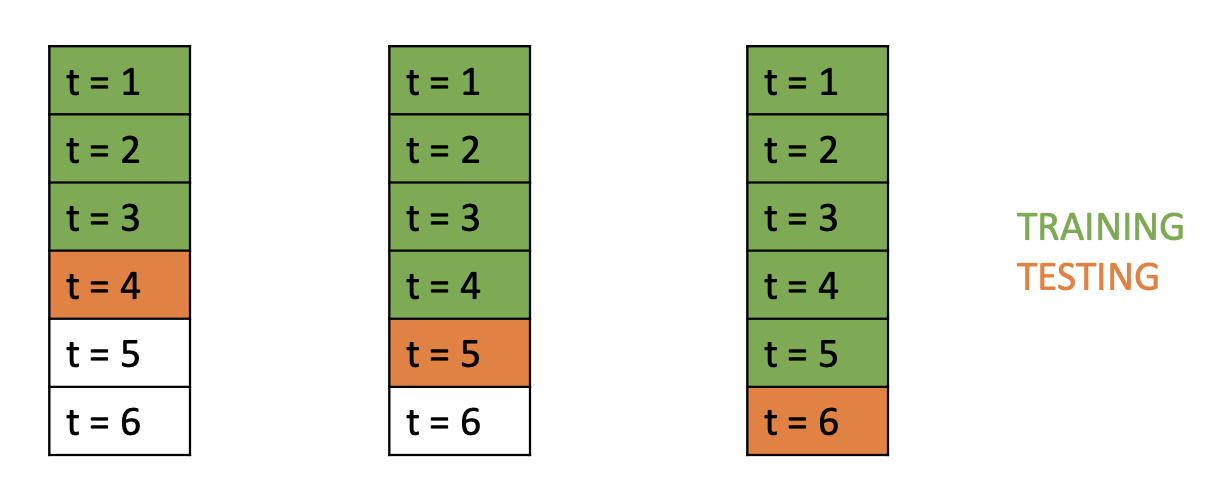

The assumption we are making here is that we are retraining the model at every time step. In some situations, we might only be able to retrain every 2 timesteps. In that case, it would make sense to include two timesteps in every fold.

Explaining validation methods for time series is a very important interview question

# Downfall of Using Tree Based Methods

Tree based methods are a popular class of machine learning algorithms. However, they have a very important property to keep in mind in a time series context. Essentially, tree based algorithms are not capable of extrapolating multiple time periods in the future. To illustrate this consider the following example. This is an example of a linearly increasing time series. 

In order for this example to work properly please restart at the top of this section if you decide to make modifications to the code cells

In [16]:
df = pd.DataFrame({'x': np.linspace(0, 70, 71)}).reset_index()
df['y'] = df['x'] * 10

alt.Chart(df).mark_line().encode(x = 'x', y = 'y')

alt.Chart(...)

This requires us to drop the first record because it has no feature values. If you decide to use more lagged variables, you will have to omit the first N observations. 

In the end of the training dataset we have a value of 49 which if we were forecasting multiple time periods in the future would be the latest estimate for the value. Therefore the x value in the testing set would be 49

In [17]:
train = df[df.index<50].copy()
test = df[df.index>=50].copy()
train.tail()

,index,x,y
45,45,45.0,450.0
46,46,46.0,460.0
47,47,47.0,470.0
48,48,48.0,480.0
49,49,49.0,490.0


In [20]:
test.head()

,index,x,y,x_
50,50,50.0,500.0,49
51,51,51.0,510.0,49
52,52,52.0,520.0,49
53,53,53.0,530.0,49
54,54,54.0,540.0,49


In [19]:
test['x_'] = 49

We now fit a random forest model. The logic here extends to all tree based methods regardless of parameter tuning

In [24]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf = rf.fit(X = df[['x']], y = df['y'])

In [25]:
train['pred'] = rf.predict(train[['x']])
test['pred'] = rf.predict(test[['x_']])

C:\Users\huang\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- x_
Feature names seen at fit time, yet now missing:
- x

  warnings.warn(message, FutureWarning)


In [26]:
chart_data = pd.concat([train, test])
chart_data = pd.melt(chart_data, id_vars = 'x', value_vars = ['y', 'pred'])
alt.Chart(chart_data).mark_line().encode(x = 'x', y = 'value', color = 'variable')

alt.Chart(...)

This error occurs because we are trying to use one model to forecast multiple time periods. If we wanted to use tree based models for this purpose, we would have to use a separate tree based model for every unique time period we want to forecast. For example, if we needed the forecast for the next six hours, we would have to build separate models for hr + 1, hr + 2, hr + 3, hr + 4, hr + 5, and hr + 6

In [27]:
chart_data.head()

,x,variable,value
0,0.0,y,0.0
1,1.0,y,10.0
2,2.0,y,20.0
3,3.0,y,30.0
4,4.0,y,40.0
